Blankenbach Benchmark Case 1
======

Steady isoviscous convection
----

This is a benchmark case of two-dimensional, incompressible, bottom heated, steady isoviscous thermal convection. This example is based on case 1 in Blankenbach *et al.* 1989 for a single Rayleigh number.

**This lesson introduces the concepts of:**
1. basics of underworld
2. setting up meshes (grids)
3. setting initial conditions
5. loading initial conditions from file
4. setting boundary conditions
5. integrating these forward in time until steady state conditions are found
6. plotting physical quantities on meshes
8. saving underworld variables to file


**References**

1. B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract


Load python functions needed for underworld.

In [11]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Set physical values for test. Particularly the simulation resolution (*res*) and simulation box size.

In [12]:
dim = 2
Box_Height = 1.0
Box_Length = 1.0
Temp_Min = 0.0
Temp_Max = 1.0
# set the resolution
res = 64

Choose which case from Blankenbach paper, or set values manually

In [13]:
case = 'a' # 'a', 'b' or 'c'
if(case=='c'):
    Ra=1.e6
    eta0=1.e21
elif(case=='b'):
    Ra=1.e5
    eta0=1.e22
else: # case a and default
    Ra=1.e4
    eta0=1.e23
# enter Ra and eta0 below here if required

Firstly, set physical density and gravity contant in SI units

In [14]:
rho = 4.0e3
grav = 10
height = 1.e6
kappa = 1.0e-6

# calculate scaling for stress
scale_topo = eta0*kappa/(rho*grav*height*height)

Set input and output file directory paths

In [15]:
inputPath = 'BBInput/'
outputPath = 'BBOutput/'

Create mesh objects. These store the indices and spatial coordiates of the grid points on the mesh.

In [16]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(res,res), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(Box_Length, Box_Height))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [17]:
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

Initial conditions
=====

Either set by rough function or load data from file.

In [18]:
LoadFromFile = True

If loading from file
------

Read 64\*64 data stored as a numpy array from numpy formatted binary file. Have saved data files for 3 values of Rayleigh number. Will use the closest of $Ra = 10^4$, $10^5$ or $10^6$. Once loaded the data will need to be re-meshed onto a new grid, unless the new resolution is also 64\*64.

For more information on re-meshing see **Remesh.ipynb**


In [19]:
if(LoadFromFile == True):
# set up mesh for 64*64 data file
    elementMesh64 = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"), 
                                         elementRes=(64, 64), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(Box_Length, Box_Height))
    linearMesh64   = elementMesh64
    temperatureField64 = uw.fevariable.FeVariable( feMesh=linearMesh64,   nodeDofCount=1 )
# determine which stored Ra number is closest
    logRa=int(math.log10(Ra))
    if(logRa<4):
        logRa=4
    if(logRa>6):
        logRa=6
    if(logRa == 4):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e4.out')
        print 'Loading 64*64 for Ra = 1e4'
    elif(logRa == 6):
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e6.out')
        print 'Loading 64*64 for Ra = 1e6'
    else:
        temperatureField64.load(inputPath+'tempfield_inp_64_Ra1e5.out')
        print 'Loading 64*64 for Ra = 1e5'
    if(res==64): # no remeshing needed, copy directly
        temperatureField = temperatureField64
    else: # remeshing needed
        temperatureField.data[:] = temperatureField64.evaluate(linearMesh)
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.

Loading 64*64 for Ra = 1e4


If _not_ loading from file: Initialise data
-----

Start with a perturbed temperature gradient to speed up the convergence to the benchmark steady state solution. Note that we are also changing the boundary values here.

In [20]:
if(LoadFromFile == False):
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    temperatureField.data[:] = 0.
    pertStrength = 0.1
    DeltaTemp = Temp_Max - Temp_Min
    for index, coord in enumerate(linearMesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/Box_Length ) * math.sin( math.pi * coord[1]/Box_Length )
        temperatureField.data[index] = Temp_Min + DeltaTemp*(Box_Height - coord[1]) + pertStrength * pertCoeff
        temperatureField.data[index] = max(Temp_Min, min(Temp_Max, temperatureField.data[index]))

Boundary conditions
========

(1) Check boundary conditions
---------

This step is often redundant as the values are set along with the initial conditions. It is included here to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have set different values on the boundaries.

In [21]:
for index in linearMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = Temp_Max
for index in linearMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = Temp_Min

(2) Determine boundary mesh vertices
------

Underworld includes functions for listing special sets of vertices on the mesh. To see the list of them run the following command

In [22]:
linearMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [23]:
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]

(3) Set the boundary values
--------

Dirichlet boundary conditions are easy to set up in **underworld**. These are any conditions of the form
\\[
y(a) = \alpha \quad \quad y(b) = \beta
\\]
which are set below for the velocity vector field and temperature scalar fields along the boundaries (IWalls, JWalls). The values for the boundaries are what ever is in the variables before this step, in this case the initial conditions set above. For example a set of tuples containing $v_x$ and $v_y$ for the velocity field will be preserved for all time on the boundaries (IWalls, JWalls) by the first command below. While the temperature is only held constant on the top and bottom boundaries (JWalls) by the second command below.

Note that through this function, we are flagging to the system that these vertices are to be considered as boundary conditions.

In [24]:
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              nodeIndexSets=(IWalls,JWalls) )
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

Plot initial conditions for temperature
======

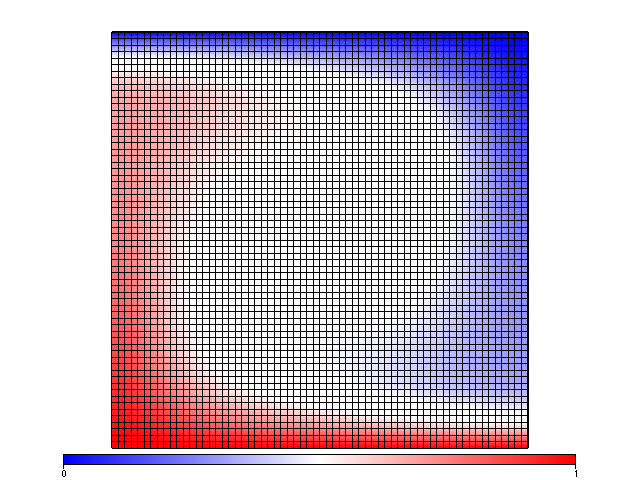

In [25]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, linearMesh, colours="blue white red")
figtemp.Mesh(linearMesh, colourBar = False)
figtemp.show()

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

Notes:
1. temperature must be in the range 0-1 for use with the denisity function defined using the Rayleigh number
2. gravity has a positive sign in the vertical direction due to how the density is defined. The density should be negatively proportional to the temperature field so that high temperature has low density. Both of these should have a negative so that the buoyancy function becomes positive. Here we simply write density and gravity as positive to achieve the same result.

In [26]:
# this can be replaced by a function
viscosityFn = fn.misc.constant(1.0)

# since Ra is a constant (defined above) and temperature is a FEvariable, then densityFn will also be an FEvariable.
densityFn = Ra * temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = densityFn * z_hat

# the temperature gradient is useful in the analysis below and is defined using a function in-built to the FEvariable.
gradField = temperatureField.gradientFn

In the cell above the *densityFn* and the *buoyancyFn* are written as functions of existing FE variables. This means that they will keep this functionality for the entire simulation. So the density will always be subject to this function.

By setting the system up in this way we only need to set these functions once at the beginning and not each timestep.

Setup a Stokes system
======

In this system the velocity field, pressure, viscosity and buoyancy forces need to be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the freeslip boundary conditions for the velocity field.

This system is solved after each time step using the .solve function (see main loop below).

In [27]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              viscosityFn=viscosityFn, 
                              bodyForceFn=buoyancyFn )


Nusselt number
------

The Nusselt number is the ratio between convective and conductive heat transfer and can be calculated by the following integral
\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]





The following function evaluates the vertical (z) component [1] of the gradient function of the temperature field at the top boundary. The function is called in the main time loop below.

In [28]:
def FindNusseltNumber(temperatureField, linearMesh, xmax, zmax):
    tempgradField = temperatureField.gradientFn
    vertGradField = tempgradField[1]
    BottomInt = 0.0
    GradValues = temperatureField.gradientFn[1].evaluate(linearMesh.specialSets["MaxJ_VertexSet"])
    TopInt = sum(GradValues)
    for index in linearMesh.specialSets["MinJ_VertexSet"]:
        BottomInt += temperatureField.data[index]
    Nu = -zmax*TopInt/BottomInt
    return Nu[0]

This function is used to determine the initial Nusselt number in the following way

In [29]:
Nu = FindNusseltNumber(temperatureField, linearMesh, Box_Length, Box_Height)
print 'Initial Nusselt number = ',Nu

Initial Nusselt number =  4.84821701165


Evaluate function
-----

The function defined above used the evaluate function which is a useful function built into underworld. When applied to the following structures, it allows:
1. FeVariables: liner interpolation at a specified point
2. other functions: evaluate the function at a point where possible

The evaluate function returns a numpy float array, which can be accessed by .data in underworld. In the previous function example this would be GradValue.data

Non-dimensional rms velocity
----
For comparison with the Blankenbach benchmark results the root mean squared velocity is used. This is defined by intergrating over the entire simulation domain via
\\[
\begin{aligned}
v_{rms} & = \frac{h}{\kappa} \left[ \frac{1}{hl} \int_0^l \int_0^h (u^2 + w^2) dz dx  \right]^{1/2} \\
 & =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) dV } {\int_V dV} }
\end{aligned}
\\]
where $V$ denotes the entire 'volume' of the box, which is the x, z surface for a 2D simulation.

This can be setup in underworld by defining the following functions as integrals of other functions. Here v2sum_integral is defined as the integral over the entire mesh of the function which is $\mathbf{v}.\mathbf{v}$. This is used in the main time loop to calculate statistics and compare to the benchmark results when the system is in steady-state.

In [30]:
vdotv = fn.math.dot(velocityField,velocityField)
v2sum_integral  = uw.utils.Integral( feMesh=linearMesh, fn=vdotv )
volume_integral = uw.utils.Integral( feMesh=linearMesh, fn=1. )

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [31]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,], )

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

**If loading from a file** then a quick number of steps are taken to compare to known benchmark values for the underworld code.

In [32]:
time = 0.
steps = 0
if(LoadFromFile == True):
    steps_end = 1
else:
    steps_end = 5000
steps_output = min(100,steps_end/10)
steps_output = max(steps_output,1)
timevals = []
vrmsvals = []
NuLast = -1.0
iloop = True
epsilon = 1.e-8
velplotmax = 0.0

Next the time steps are carried out until the maximum number of steps is reached, or until the relative change in the Nusselt number is less than the criteria value (epsilon). 

The loop itself consists of:
1. solving the Stokes system
2. determining the maximum timestep (dt) for advancing the advection-diffusion system
3. calculating new velocities by integrating the advection-diffusion system with the maximum timestep
4. calculate and store the statistical quantities ($v_{rms}$ and $Nu$)
5. check that the Nusselt number is still changing sufficiently to require another loop
6. increment number of time steps and the time and loop again

In [33]:
# Perform steps
while iloop == True:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    # Calculate the RMS velocity and Nusselt number
    v2sum = v2sum_integral.integrate()
    volume = volume_integral.integrate()
    rms_v = math.sqrt(v2sum[0])/volume[0]
    Nu = FindNusseltNumber(temperatureField, linearMesh, Box_Length, Box_Height)
    # store v_rms and time
    vrmsvals.append(rms_v)
    timevals.append(time)
    velplotmax = max(rms_v,velplotmax)
    # check loop break condition
    if(abs((Nu - NuLast)/Nu) < epsilon):
        iloop = False
        print 'steps = {0:6d}  ;time = {1:.3e}  ;v_rms = {2:.3f}  ;Nu = {3:.3f}  ;Rel change = {4:.3e}'.format(steps,time,rms_v,Nu,abs((Nu - NuLast)/Nu))
    if steps%(steps_end/steps_output) == 0:
        print 'steps = {0:6d}  ;time = {1:.3e}  ;v_rms = {2:.3f}  ;Nu = {3:.3f}  ;Rel change = {4:.3e}'.format(steps,time,rms_v,Nu,abs((Nu - NuLast)/Nu))
    if steps>=steps_end:
        iloop = False
    # Increment time and timestep counter and save previous Nusselt number
    time += dt
    steps += 1
    NuLast = Nu


steps =      0  ;time = 0.000e+00  ;v_rms = 42.858  ;Nu = 4.848  ;Rel change = 1.206e+00
steps =      1  ;time = 0.000e+00  ;v_rms = 42.858  ;Nu = 4.848  ;Rel change = 9.878e-09
steps =      1  ;time = 0.000e+00  ;v_rms = 42.858  ;Nu = 4.848  ;Rel change = 9.878e-09


Benchmark values
====

The time loop above outputs $v_{rms}$ and $Nu$ as general statistics for the system. For comparison, the benchmark values for the RMS velocity and Nusselt number are shown below for different Rayleigh numbers. All benchmark values shown below were determined in Blankenbach *et al.* 1989 by extroplation of numerical results. 


| $Ra$          | $v_{rms}$   | $Nu$  |   $q_1$  | $q_2$  |
| ------------- |:-------------:|:-----:|:-----:|:-----:|
| 10$^4$ | 42.865 |  4.884 | 8.059 | 0.589 |
| 10$^5$ | 193.215 | 10.535 | 19.079 | 0.723 |
| 10$^6$ | 833.990 | 21.972 | 45.964 | 0.877 |


For practicality, quick tests can be run to see that the results are close enough. Tests run using underworld gave

| $Ra$          | $v_{rms}$   | $Nu$  |
| ------------- |:-------------:|:-----:|
| 10$^4$ | 42.858 |  4.848 |
| 10$^5$ | 193.449 | 10.248 |
| 10$^6$ | 844.218 | 19.660 |


Resulting temperature field
======

Use the same method as above to plot the new temperature field. This can also be used to plot the pressure field, or any other data structures of interest.

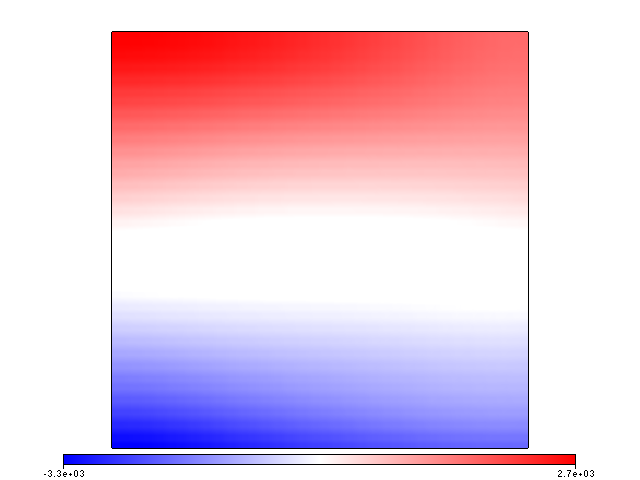

In [34]:
#PgradField = pressureField.gradientFn
figtemp = plt.Figure()
figtemp.Surface(pressureField, linearMesh, colours="blue white red")
figtemp.show()

Save temperature data
======

Save the temperature field data to two file using HDF5 (binary) format. This is the same file type as is loaded above.

In [35]:
temperatureField.save(outputPath+'tempfield.out')

Plot the velocity vector field
------

For this example the velocity field is interesting to see. This is visualised in two ways, firstly plotting a surface colour map of the velocity magnitude, and secondly the velocity vectors at points on the mesh. For aesthetics the vector arrows are scaled by a little more than the maximum $v_{rms}$ value found in the time loop above.

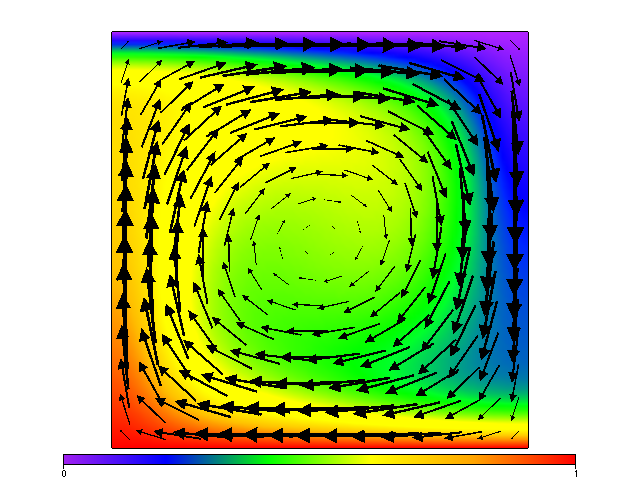

In [36]:
fig2 = plt.Figure()
velmagfield = uw.function.math.sqrt(uw.function.math.dot(velocityField,velocityField))
fig2.VectorArrows(velocityField/(1.5*velplotmax), linearMesh, arrowHeadSize=0.2, lengthScale=0.2)
fig2.Surface(temperatureField, linearMesh)
fig2.show()

Temperature gradient
=====

The final benchmarks in the Blankenbach paper involve the temperature gradient in the vertical direction ($\frac{\partial T}{\partial z}$). This is easy to find using the underworld functions, as shown below.


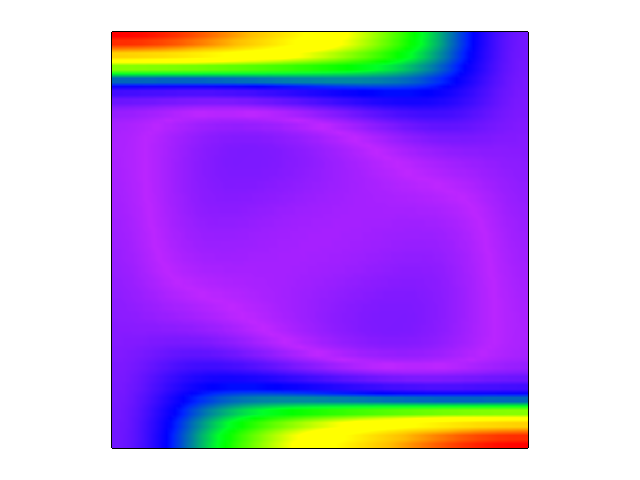

In [37]:
tempgradField = temperatureField.gradientFn
vertTGradField = - Box_Height * tempgradField[1] / Temp_Max # scaled for direct benchmarking below
fig3 = plt.Figure()
vertTGradmagField = uw.function.math.sqrt(uw.function.math.dot(vertTGradField,vertTGradField))
fig3.Surface(vertTGradmagField, linearMesh, colourBar = False, axis = True)
fig3.show()

Benchmark values
------

The vertical temperature gradient (above) is set up to be non-dimensional as per Blankenbach et al 1989. To compare to the benchmark values in their work the gradient is compared at the corners of the simulation box: $q_1$ at $x = 0$, $z = h$; $q_2$ at $x = l$, $z = h$; $q_3$ at $x = l$, $z = 0$; $q_4$ at $x = 0$, $z = 0$. Where $h$ = Box_Height and $l$ = Box_Length and the non-dimensional gradient field is given by
\\[
q = \frac{-h}{\Delta T} \left( \frac{\partial T}{\partial z} \right)
\\]

Provided the simulation is run to steady-state with sufficent resolution then the $q$ values should be close to the benchmark values given again below for different Rayleigh numbers.

| $Ra$          |    $q_1$  | $q_2$  |
| ------------- |:-----:|:-----:|
| 10$^4$ | 8.059 | 0.589 |
| 10$^5$ | 19.079 | 0.723 |
| 10$^6$ | 45.964 | 0.877 |

The underworld values for $64\times64$ close to convergence are

| $Ra$          |    $q_1$  | $q_2$  |
| ------------- |:-----:|:-----:|
| 10$^4$ | 7.998 | 0.587 |
| 10$^5$ | 18.265 | 0.710 |
| 10$^6$ | 36.383 | 0.819 |


In [38]:
q1 = vertTGradField.evaluate( (0.,Box_Height))
q2 = vertTGradField.evaluate( (Box_Length,Box_Height))
q3 = vertTGradField.evaluate( (Box_Length,0.))
q4 = vertTGradField.evaluate( (0.,0.))

print 'Rayleigh number = ',Ra
print 'q1 = ',q1
print 'q2 = ',q2
print 'q3 = ',q3
print 'q4 = ',q4

Rayleigh number =  10000.0
q1 =  [[ 7.99802019]]
q2 =  [[ 0.58670844]]
q3 =  [[ 7.99799476]]
q4 =  [[ 0.58670169]]


Save time and rms values
-------------

In [39]:
np.savetxt(outputPath+'test.out', (timevals, vrmsvals))

Calculate stress values for benchmark comparison
=====

Determine stress field for whole box in dimensionless units (King 2009)
\begin{equation}
\tau_{ij} = \eta \frac{1}{2} \left[ \frac{\partial v_j}{\partial x_i} + \frac{\partial v_i}{\partial x_j}\right]
\end{equation}
which for vertical normal stress becomes
\begin{equation}
\tau_{zz} = \eta \frac{1}{2} \left[ \frac{\partial v_z}{\partial z} + \frac{\partial v_z}{\partial z}\right] = \eta \frac{\partial v_z}{\partial z}
\end{equation}
which is implemented for the whole box below

Define functions required for stress calculation

In [40]:
def GetZDerivOfVel( coord = (0., 0.) ):
    y = fn.tensor.symmetric( velocityField.gradientFn)
    zderiv = y.evaluate( coord )[0,1]
    return zderiv

def GetStressZZ( coord= (0., 0.)):
    return GetZDerivOfVel( coord )*viscosityFn.evaluate( coord ) * 2.0


Calculate stress field for entire region

In [41]:
stressfield = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1)
for index, xcoord in enumerate(linearMesh.data):
    coord = (xcoord[0],xcoord[1])
    stressfield.data[index] = GetStressZZ(coord)

Calculate topography from the vertical normal stress at the top of the box (King 2009)
\begin{equation}
\sigma_{t} = \frac{\eta_0 \kappa}{\rho g h^2}\tau _{zz} \left( x, z=h\right)
\end{equation}
where all constants have been defined above. 

The total stress is given by
\begin{equation}
\sigma = P - \tau_{zz}
\end{equation}
where the stress in physical units ($\sigma$) is scaled from the dimensionless ($\sigma'$) via
\begin{equation}
\sigma = \frac{\eta_0 \kappa}{h^2} \sigma'
\end{equation}
and the topography is defined using $h = \sigma_{top} / (\rho g)$.

Firstly the vertical normal stress along the top ($\tau_{zz}$) needs to be determined. This involves getting the pressure and stress along the top boundary and shifting each of them such that their mean value is zero.


In [42]:
x = []
P = []
tauz = [] # deviatoric stress (vertical component)
meanP = 0.0
meantauz = 0.0
counttop = 0
for index, xcoord in enumerate(linearMesh.data):
    if index in linearMesh.specialSets["MaxJ_VertexSet"]:
        x.append(xcoord[0])
        tauz.append(stressfield.data[index][0])
        meantauz+=stressfield.data[index][0]
        P.append(pressureField.evaluate( (xcoord[0],xcoord[1]))[0][0])
        meanP+=pressureField.evaluate( (xcoord[0],xcoord[1]))[0][0]
        counttop += 1

meanP = meanP/float(counttop)
meantauz = meantauz/float(counttop)
for i in range(0,counttop):
    tauz[i]=tauz[i]-meantauz
    P[i]=P[i]-meanP

Combine both together to get the topography, including the scaling,
\begin{equation}
\sigma = \frac{\eta_0 \kappa}{h^2} \left( P - \tau_{zz} \right)
\end{equation}

In [43]:
topography = P[:]
for i in range(0,counttop):
    topography[i] = (P[i] - tauz[i]) * scale_topo

Calculate x-coordinate at zero stress
------

Calculate the zero point for the stress along the x-axis using the interpolation function from numpy. Note that numpy requires that the first array input for np.interp must be increasing, so this needs to be tested to see if it is monotonic. If it is not then the temporary array y is reversed, which will not change the zero point.

In [44]:
y = topography[:]
if (np.all(np.diff(y) > 0) == True): # check if monotonic
    x_xizero = np.interp(0.0,y,x)
else: # if not monotonic then take the negative of temporary array so it becomes monotonic
    for i in range(len(y)):
        y[i]=-1.*y[i]
    x_xizero = np.interp(0.0,y,x)


Topography comparison
-------

Topography of the top boundary calculated in the left and right corners as given in Table 9 of Blankenbach et al 1989.

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2254.02   | -2903.23  | 0.539372          |
| 10$^5$  | 1460.99   | -2004.20  | 0.529330          |
| 10$^6$  | 931.96   | -1283.80  | 0.506490          |

Underworld values for an "almost" converged $64\times64$ benchmark run

| $Ra$          |    $\xi_1$  | $\xi_2$  |  $x$ ($\xi = 0$) |
| ------------- |:-----------:|:--------:|:--------------:|
| 10$^4$  | 2232.97   | -2913.69  | 0.541370          |
| 10$^5$  | 1439.51   | -2003.27  | 0.531073          |
| 10$^6$  | 894.725   | -1270.389  | 0.510494         |


In [45]:
print 'Rayleigh number = ',Ra
print 'Topography[x=0],[x=max] = ',topography[0],topography[len(topography)-1]
print 'x(topo=0) = ',x_xizero

Rayleigh number =  10000.0
Topography[x=0],[x=max] =  2232.9669804 -2913.68574813
x(topo=0) =  0.54137001178
